The codes an examples mentioned belows are taken from [**IBM Qiskit / Teleportation**](https://qiskit.org/textbook/ch-algorithms/teleportation.html#4.-Understanding-Quantum-Teleportation-) and the other refferences mention in **Reference Pages**. We can simulate quantum  teleportation using Qiskit, we will use Qiskits  simulator to test our circuit than run it on  real quantum computer. Our circuit will teleport the quantum state of a qubit to another qubit.


# Imports and authentication :
We Begin with loading the **Qiskit Simulator(IBM)**  and provide authentication information as bellow :

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit import IBMQ
IBMQ.save_account('972d8d1fbe0499640c9d1e9ebfd18fe99f8b6329199e478024196160cc0fec5aeb9916dd810d5ae665f3fa1502529657c5e178b6171193894b33b865e25f42f1')
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2021-10-21 20:50:40,072: Credentials already present. Set overwrite=True to overwrite.


The create the circuit , we also use  the additional and  necessary  imports  as follows: 

In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import  transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector

Using  3 qubits and 2 classical bits in 2 different registers 

In [4]:
qr = QuantumRegister(3, name="q")    
crz = ClassicalRegister(1, name="crz") 
crx = ClassicalRegister(1, name="crx") 
teleportation_circuit = QuantumCircuit(qr, crz, crx)

 To create a Bell pair between two qubits is to first transfer one of them to the X-basis (|+>⟩ and (|->) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis.

In [5]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) 
    qc.cx(a,b)

Using  3 qubits and 2 classical bits in 2 different registers

In [6]:
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

Entangles qubits q1 and q2 and  view the circuit so far:


In [7]:
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

Lets assume that Alice has got q1 and Bob got q2 before the depart from each other.

lice applies a CNOT gate to q1  controlled by |ψ⟩(the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to |ψ⟩ .In our quantum circuit, the qubit |ψ⟩  Alice is trying to send is q0.

In [8]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

Using 3 qubits and 2 classical bits in 2 different registers:

In [9]:
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

Step 1: Creating Bell pairs:

In [10]:
create_bell_pair(teleportation_circuit, 1, 2)


Step 2 : Use barrier to separate steps, it will make it easier to understand the circuit.
Visualize the progress . 

In [11]:
teleportation_circuit.barrier() 
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

Step 3 Alice applies a measurement to both qubits q1 and  |ψ⟩ that she owns and d stores this result in two classical bits. She then sends these two bits to Bob.

In [12]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

 Use barrier to separate steps.Measure and draw the circuit.

In [13]:
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()


░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

Bob, who already has the qubit q2, then applies the following gates depending on the state of the classical bits: 
00  →  Do nothing .
01  →  Apply X gate.
10  →  Apply Z  gate
11  →  Apply ZX gate.
This function takes a QuantumCircuit (qc), integer (qubit) and ClassicalRegisters (crz & crx) to decide which gates to apply

Here we use c_if to control our gates with a classical bit instead of a qubit. 
Apply gates if the registers are in state 1.


In [14]:
def bob_gates(qc, qubit, crz, crx):
    
    qc.x(qubit).c_if(crx, 1)  
    qc.z(qubit).c_if(crz, 1) 

Using  3 qubits and 2 classical bits in 2 different registers


In [13]:
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)



STEP 1, create bell pair 


In [14]:

create_bell_pair(teleportation_circuit, 1, 2)


Step 2:  Use barrier to separate steps


In [15]:
teleportation_circuit.barrier() 
alice_gates(teleportation_circuit, 0, 1)



STEP 3 : Measurement and send 

In [16]:
measure_and_send(teleportation_circuit, 0, 1)



STEP 4 : Use barrier to separate steps


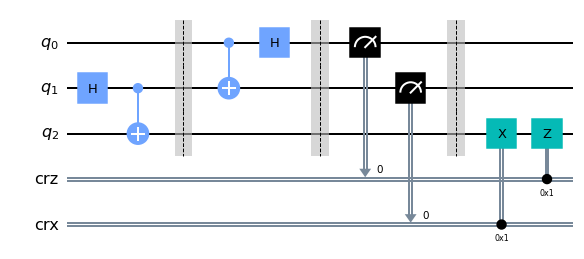

In [17]:
teleportation_circuit.barrier() 
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

At the end of this protocole Alices Qubit (q0) has been Teleported to Bob (q2) 